In [ ]:
# https://figshare.com/articles/dataset/Voice_Samples_for_Patients_with_Parkinson_s_Disease_and_Healthy_Controls/23849127?file=41836707

Validating data directories...
Found 41 healthy samples and 40 Parkinson's samples

Processing healthy samples...
Processed 1/41: AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2.wav
Processed 2/41: AH_596S_BBE9779F-C440-42D3-9C96-4CD6121D1F7E.wav
Processed 3/41: AH_904H_85B22FC1-BA09-4A17-A374-B00B2445CD27.wav
Processed 4/41: AH_292J_201CB911-31C1-4CD0-BD73-4FBA4A16C21F.wav
Processed 5/41: AH_456K_CBF60DD0-82AA-430E-A5E9-E1D3AE175CCB.wav
Processed 6/41: AH_888A_7F1444B0-B12C-4B55-AF2A-463395DCAF3C.wav
Processed 7/41: AH_942A_3F7867F3-1AE2-4BE6-B5EC-AC3157D310CF.wav
Processed 8/41: AH_444B_E1586F09-1BF5-408D-A55E-96D9E8B76A43.wav
Processed 9/41: AH_789Y_20CB672C-5F66-425E-8707-BE5B7FF807E2.wav
Processed 10/41: AH_469Z_5BB05B2C-39C4-434D-9445-244E7580F840.wav
Processed 11/41: AH_667J_605FB4D5-E0DB-4B9B-8F58-784561C51693.wav
Processed 12/41: AH_420J_07C96C2C-6E96-4A2F-BEC9-5CB71DB309B6.wav
Processed 13/41: AH_678A_2E7AFA48-34C1-4DAD-A73C-95F7ABF6B138.wav
Processed 14/41: AH_501F_4BDDBB93-EA9

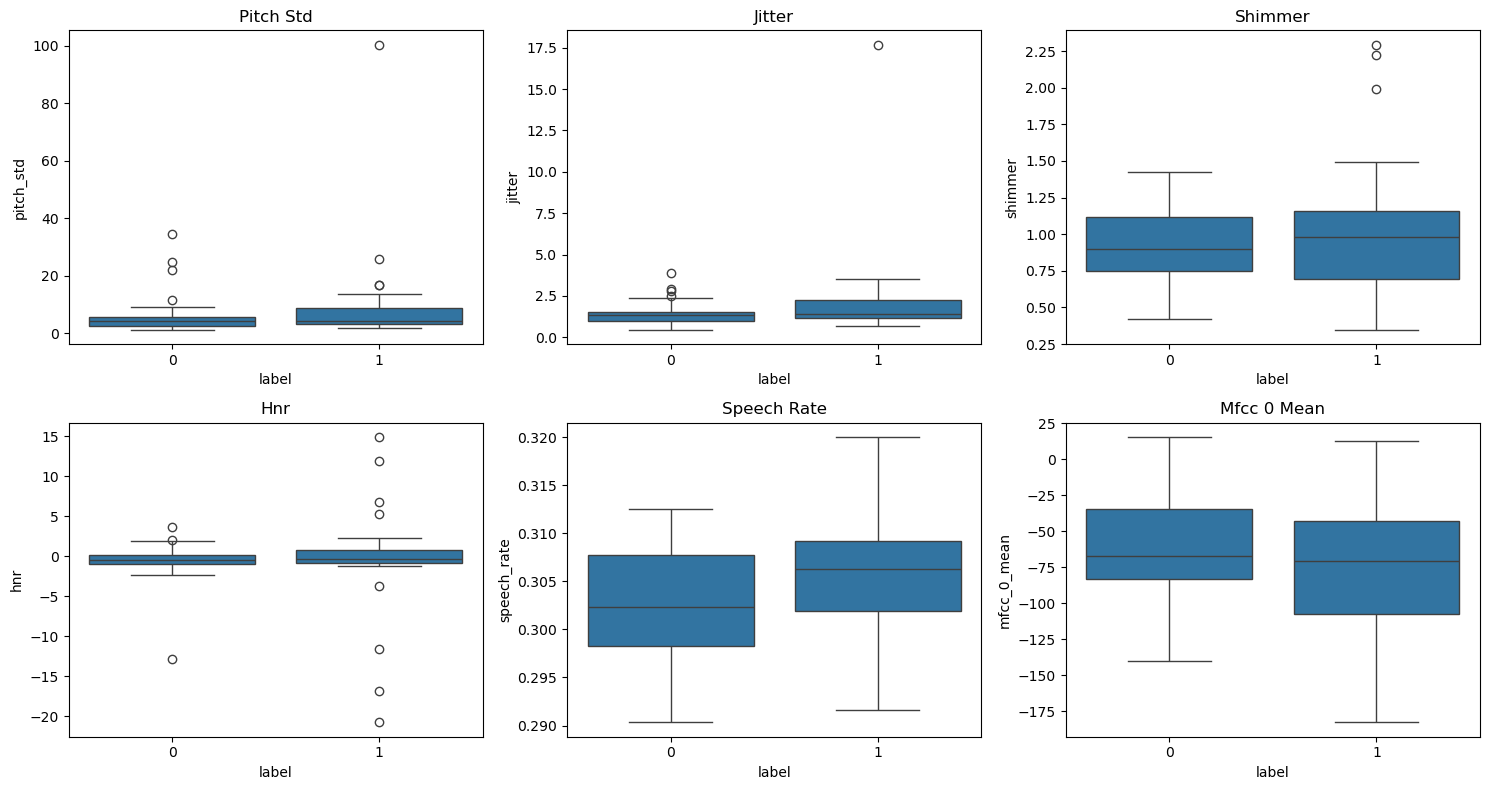


Training models...

=== Training SVM ===
Test Accuracy: 0.647
Test AUC: 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.50      0.67      0.57         6

    accuracy                           0.65        17
   macro avg       0.64      0.65      0.64        17
weighted avg       0.68      0.65      0.65        17



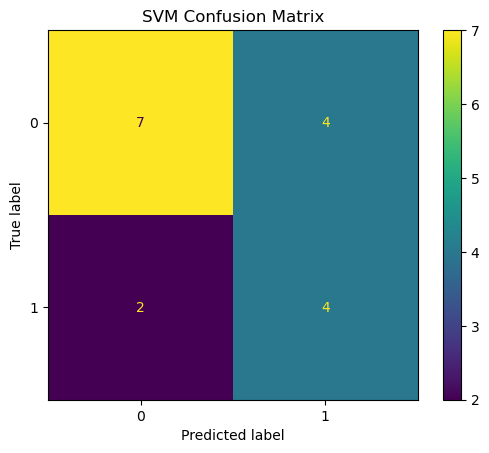

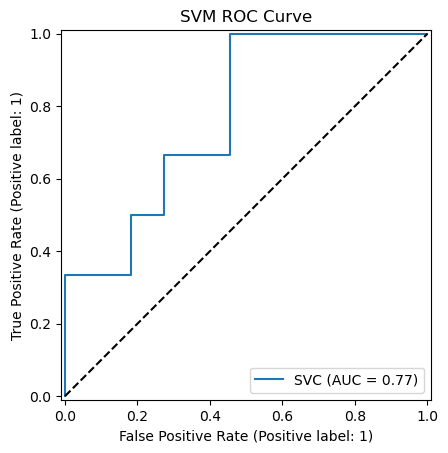


=== Training RandomForest ===
Test Accuracy: 0.471
Test AUC: 0.652
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.36      0.67      0.47         6

    accuracy                           0.47        17
   macro avg       0.52      0.52      0.47        17
weighted avg       0.56      0.47      0.47        17



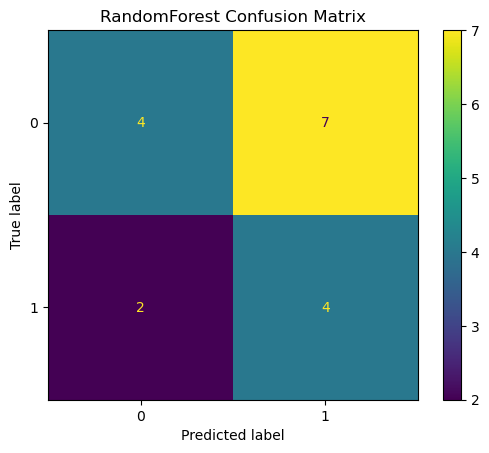

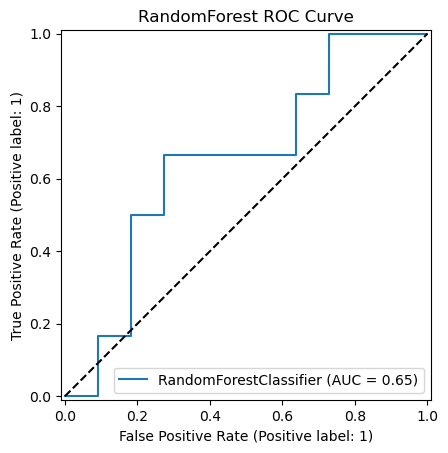


Saved models to parkinson_models.pkl

Top 10 Important Features:
                  Feature  Importance
0              pitch_mean    0.148400
8   spectral_centroid_std    0.082773
4                 shimmer    0.079198
14            speech_rate    0.078341
10            mfcc_1_mean    0.075364
12            mfcc_3_mean    0.072748
11            mfcc_2_mean    0.065664
6            tremor_index    0.063011
2             pitch_range    0.057650
3                  jitter    0.055968


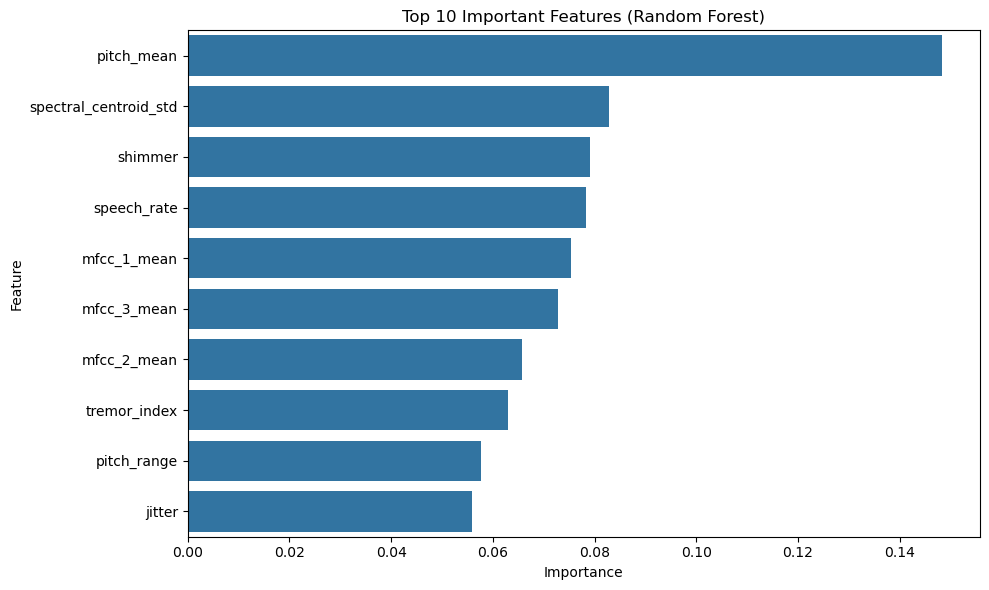

In [29]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay, 
                           RocCurveDisplay, roc_auc_score)
from sklearn.pipeline import Pipeline

# ======================== CONFIGURATION ========================
HEALTHY_DIR = "/Users/rajatsingh/Desktop/parkinsons_audio/healthy_audios"
PARKINSONS_DIR = "/Users/rajatsingh/Desktop/parkinsons_audio/parkinsons_audios"
MODEL_SAVE_PATH = "parkinson_models.pkl"
FEATURES_CSV_PATH = "parkinsons_audio_features.csv"

# ======================== DATA VALIDATION ========================
def validate_data():
    """Check if data directories exist and contain files"""
    assert os.path.exists(HEALTHY_DIR), f"Directory not found: {HEALTHY_DIR}"
    assert os.path.exists(PARKINSONS_DIR), f"Directory not found: {PARKINSONS_DIR}"
    
    healthy_files = [f for f in os.listdir(HEALTHY_DIR) if f.endswith(('.wav','.mp3','.ogg'))]
    parkinsons_files = [f for f in os.listdir(PARKINSONS_DIR) if f.endswith(('.wav','.mp3','.ogg'))]
    
    assert len(healthy_files) > 0, f"No audio files found in {HEALTHY_DIR}"
    assert len(parkinsons_files) > 0, f"No audio files found in {PARKINSONS_DIR}"
    
    print(f"Found {len(healthy_files)} healthy samples and {len(parkinsons_files)} Parkinson's samples")
    return healthy_files, parkinsons_files

# ======================== FEATURE EXTRACTION ========================
def extract_features(audio_path):
    """Extract features ensuring all are scalar values"""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        features = {}

        # 1. Pitch features
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=75, fmax=600)
        valid_f0 = f0[~np.isnan(f0)]
        
        # Pitch statistics (ensure scalar outputs)
        features['pitch_mean'] = float(np.mean(valid_f0)) if len(valid_f0) > 0 else 0.0
        features['pitch_std'] = float(np.std(valid_f0)) if len(valid_f0) > 0 else 0.0
        features['pitch_range'] = float(np.ptp(valid_f0)) if len(valid_f0) > 0 else 0.0

        # 2. Jitter and shimmer (scalar)
        if len(valid_f0) > 1:
            features['jitter'] = float(np.mean(np.abs(np.diff(valid_f0))))
            amplitude = np.abs(librosa.stft(y))
            features['shimmer'] = float(np.mean(np.abs(np.diff(amplitude, axis=1))))
        else:
            features['jitter'] = 0.0
            features['shimmer'] = 0.0

        # 3. Voice quality measures (scalar)
        harmonic = librosa.effects.harmonic(y)
        percussive = librosa.effects.percussive(y)
        features['hnr'] = float(np.mean(harmonic) / (np.mean(percussive) + 1e-6))
        features['tremor_index'] = float(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]))

        # 4. Spectral features (scalar)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = float(np.mean(spectral_centroid))
        features['spectral_centroid_std'] = float(np.std(spectral_centroid))

        # 5. MFCCs (convert to individual features)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)  # Reduced from 13 to 5 for simplicity
        for i in range(5):
            features[f'mfcc_{i}_mean'] = float(np.mean(mfcc[i]))

        # 6. Rhythm features (scalar)
        rms = librosa.feature.rms(y=y)[0]
        speech_threshold = np.percentile(rms, 70)
        features['speech_rate'] = float(np.sum(rms > speech_threshold) / len(rms))
        
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

# ======================== BATCH PROCESSING ========================
def process_audio_folder(audio_dir, label):
    """Process all audio files with progress tracking"""
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith(('.wav','.mp3','.ogg'))]
    features_list = []
    
    for i, filename in enumerate(audio_files, 1):
        audio_path = os.path.join(audio_dir, filename)
        features = extract_features(audio_path)
        if features:
            features['filename'] = filename
            features['label'] = label
            features_list.append(features)
            print(f"Processed {i}/{len(audio_files)}: {filename}")
    
    return pd.DataFrame(features_list)

# ======================== DATA PREPARATION ========================
def prepare_data(df):
    """Ensure all values are numeric and finite"""
    X = df.drop(['filename', 'label'], axis=1)
    y = df['label']
    
    # Convert all columns to numeric, coercing errors
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Replace infinite values and drop NA
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    
    # Ensure we haven't dropped all columns
    if X.shape[1] == 0:
        raise ValueError("All features were invalid after preprocessing")
        
    return X, y

# ======================== MODEL TRAINING ========================
def train_and_evaluate_models(X, y):
    """Train models with simplified approach"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'SVM': SVC(kernel='rbf', C=1.0, probability=True),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5)
    }
    
    best_models = {}
    
    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Store model and metrics
        best_models[name] = {
            'model': model,
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'report': classification_report(y_test, y_pred)
        }
        
        print(f"Test Accuracy: {best_models[name]['accuracy']:.3f}")
        print(f"Test AUC: {best_models[name]['roc_auc']:.3f}")
        print("Classification Report:")
        print(best_models[name]['report'])
        
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
        plt.title(f"{name} Confusion Matrix")
        plt.show()
        
        # Plot ROC curve
        RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
        plt.title(f"{name} ROC Curve")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.show()
    
    return best_models, scaler

# ======================== VISUALIZATION ========================
def plot_feature_distributions(df):
    """Plot comparative distributions of key features"""
    plt.figure(figsize=(15, 8))
    
    features_to_plot = ['pitch_std', 'jitter', 'shimmer', 'hnr', 'speech_rate', 'mfcc_0_mean']
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='label', y=feature, data=df)
        plt.title(feature.replace('_', ' ').title())
    
    plt.tight_layout()
    plt.show()

# ======================== MAIN EXECUTION ========================
if __name__ == "__main__":
    # 1. Data validation
    print("Validating data directories...")
    healthy_files, parkinsons_files = validate_data()
    
    # 2. Feature extraction
    print("\nProcessing healthy samples...")
    healthy_df = process_audio_folder(HEALTHY_DIR, label=0)
    
    print("\nProcessing Parkinson's samples...")
    parkinsons_df = process_audio_folder(PARKINSONS_DIR, label=1)
    
    # 3. Combine and save data
    combined_df = pd.concat([healthy_df, parkinsons_df], ignore_index=True)
    combined_df.to_csv(FEATURES_CSV_PATH, index=False)
    print(f"\nSaved features to {FEATURES_CSV_PATH}")
    
    # 4. Data preparation
    print("\nPreparing data for modeling...")
    X, y = prepare_data(combined_df)
    
    # 5. Feature visualization
    print("\nPlotting feature distributions...")
    plot_feature_distributions(combined_df)
    
    # 6. Model training
    print("\nTraining models...")
    best_models, scaler = train_and_evaluate_models(X, y)
    
    # 7. Save models
    model_package = {
        'models': best_models,
        'scaler': scaler,
        'feature_names': list(X.columns),
        'class_names': ['Healthy', 'Parkinsons']
    }
    joblib.dump(model_package, MODEL_SAVE_PATH)
    print(f"\nSaved models to {MODEL_SAVE_PATH}")

    # 8. Feature importance
    rf_model = best_models['RandomForest']['model']
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(importances.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances.head(10))
    plt.title("Top 10 Important Features (Random Forest)")
    plt.tight_layout()
    plt.show()